1- mental-illnesses-prevalence.csv missing values: 
 Entity                                                                                 0
Code                                                                                 270
Year                                                                                   0
Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized      0
Depressive disorders (share of population) - Sex: Both - Age: Age-standardized         0
Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized            0
Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized            0
Eating disorders (share of population) - Sex: Both - Age: Age-standardized             0
dtype: int64
2- burden-disease-from-each-mental-illness(1).csv missing values: 
 Entity                                                                              0
Code                                                                

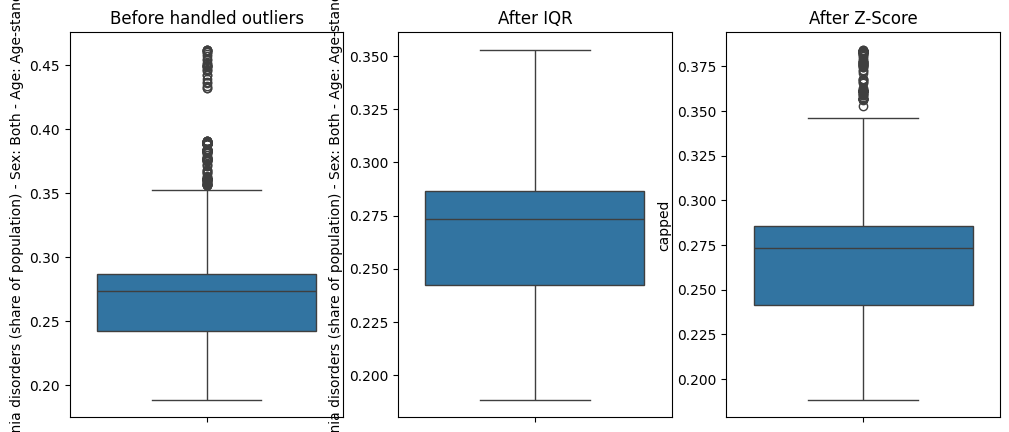

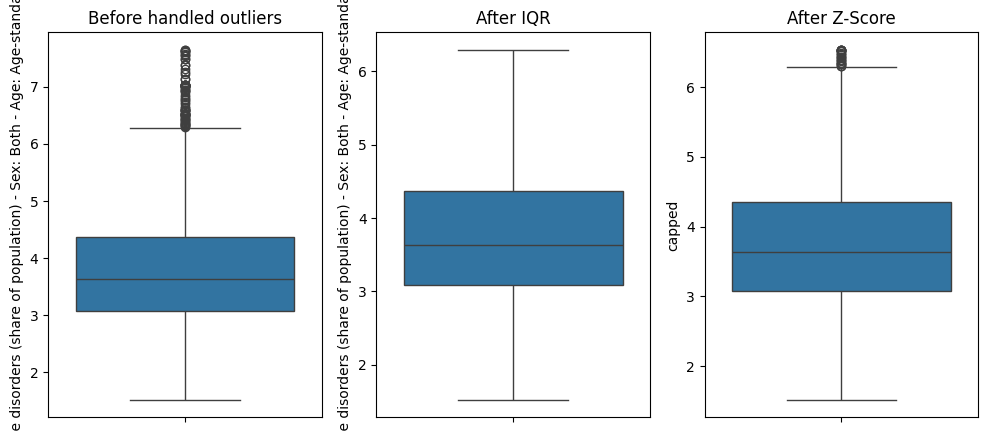

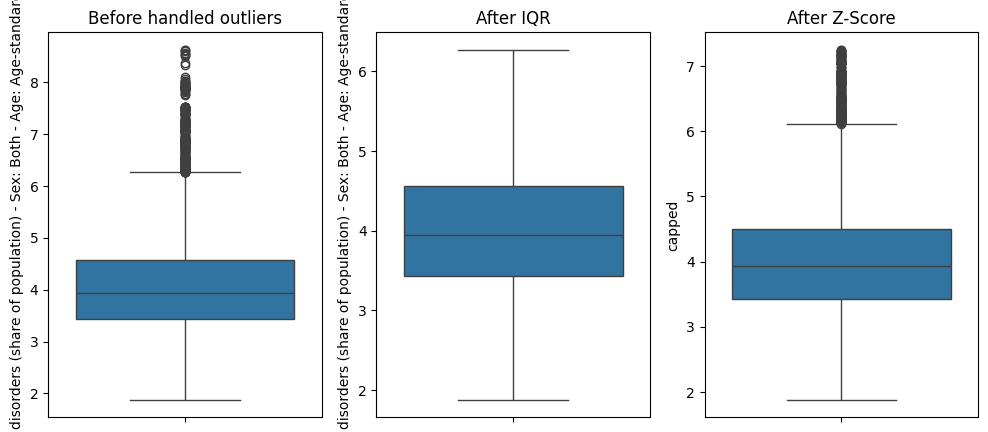

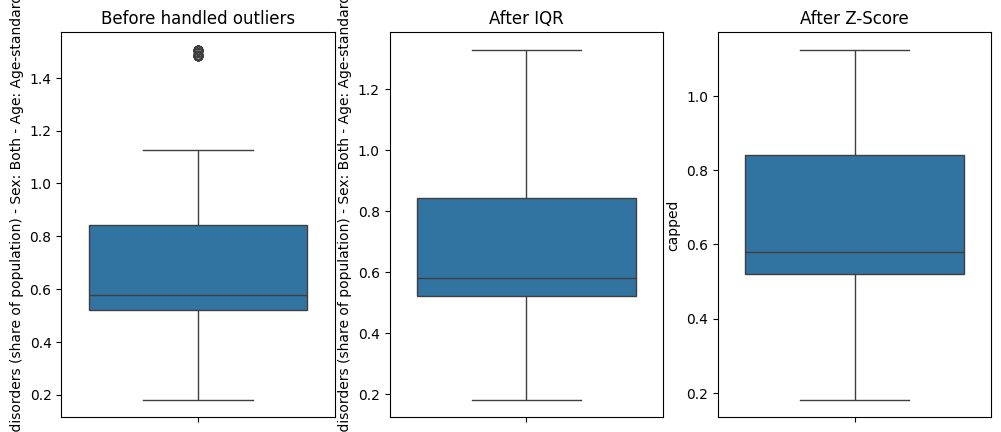

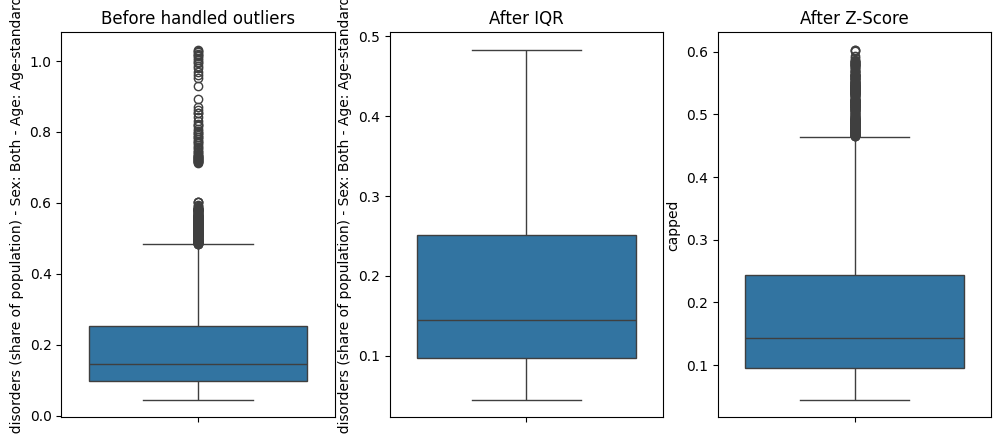

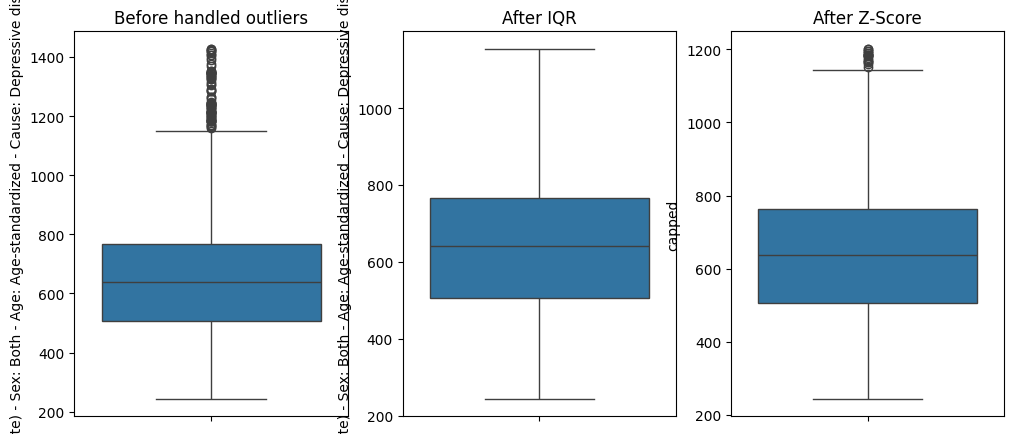

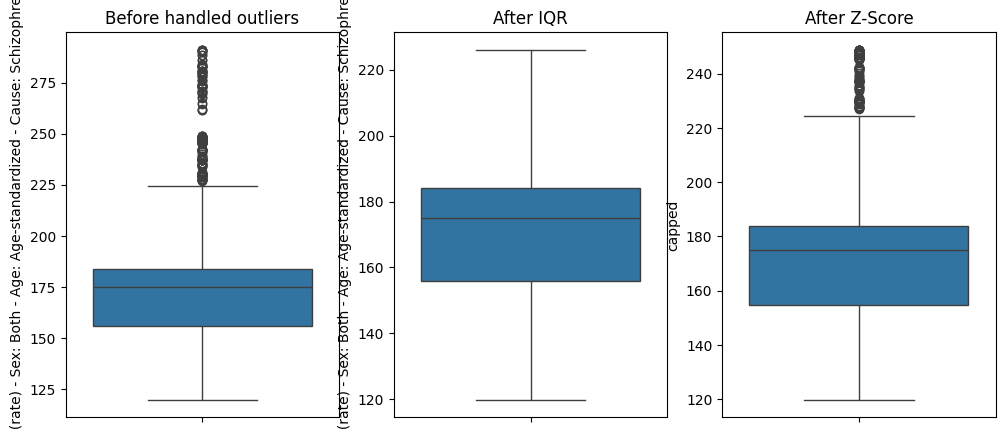

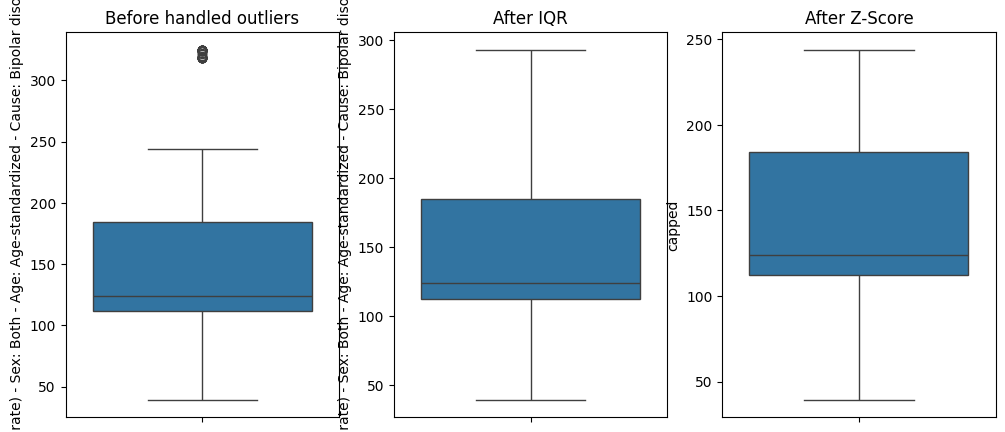

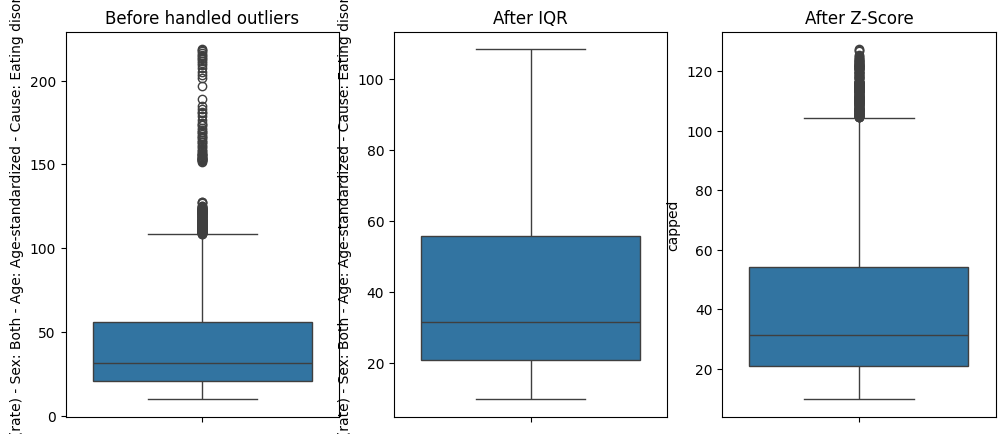

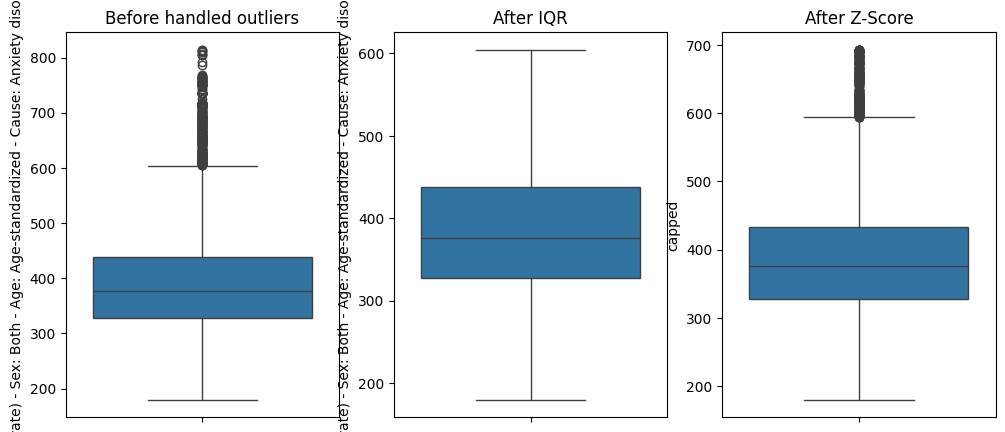

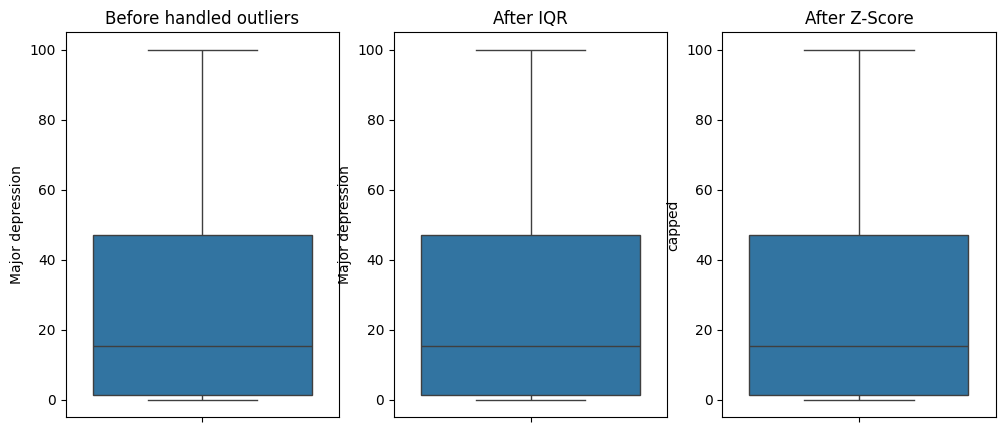

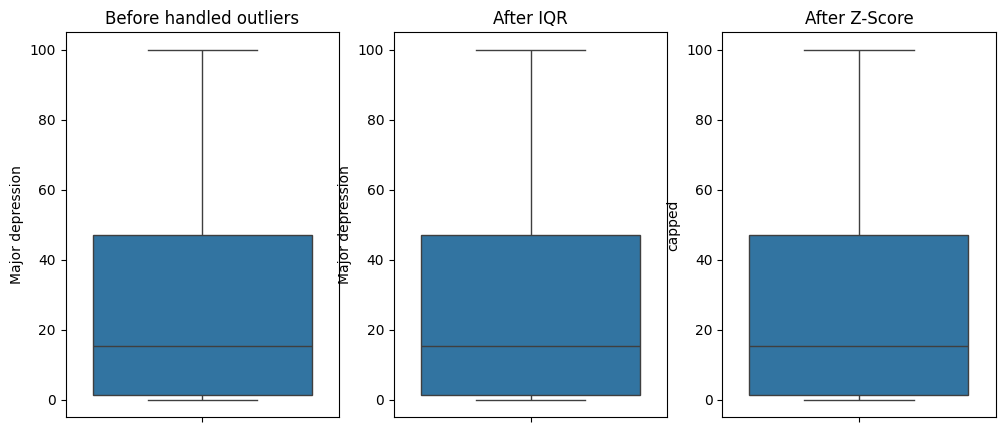

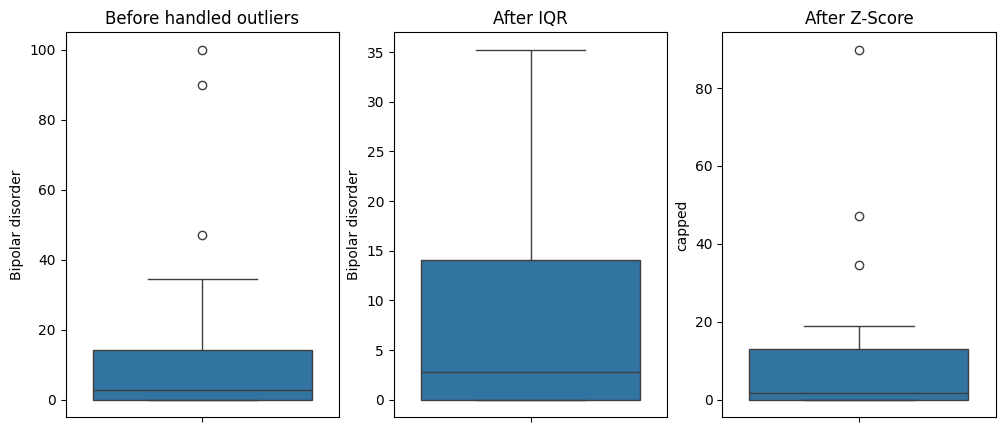

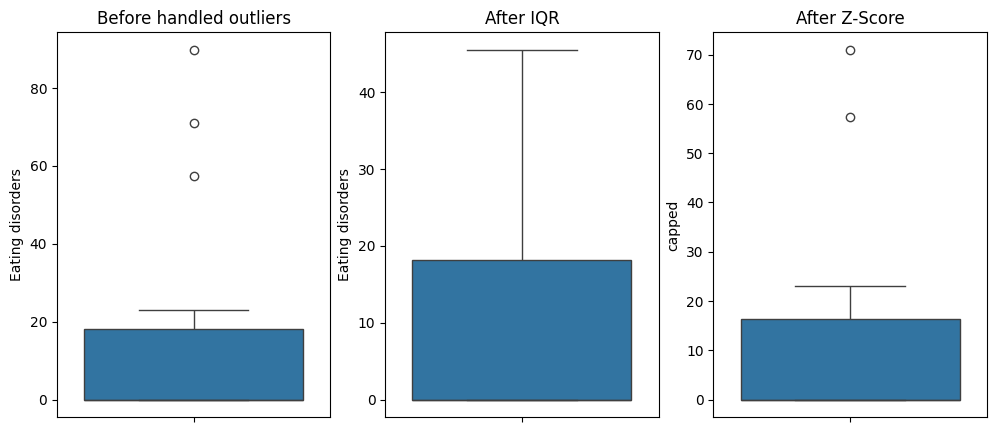

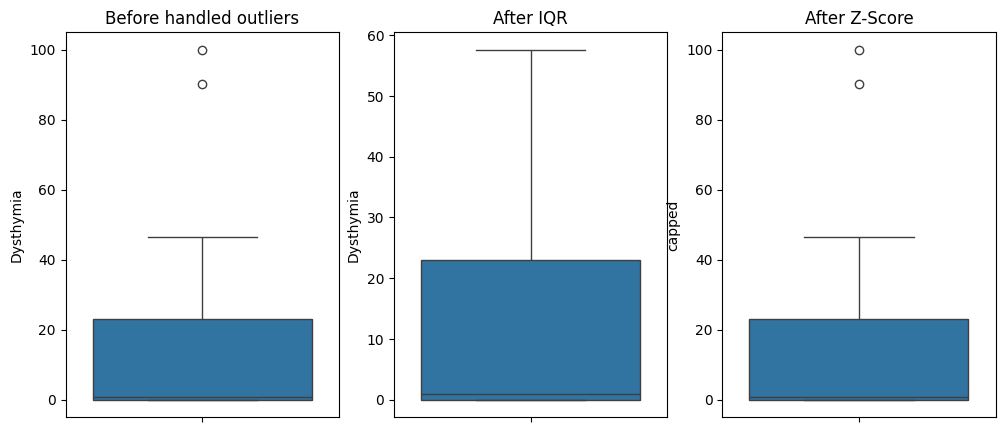

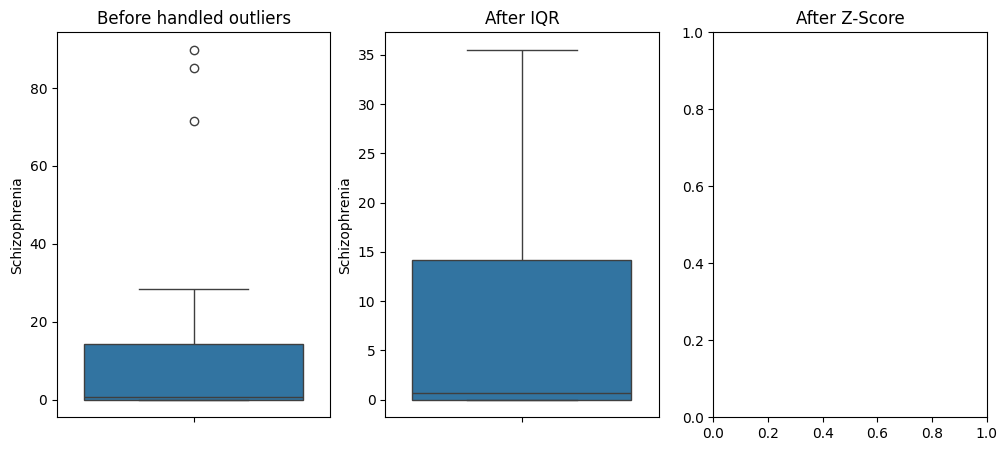

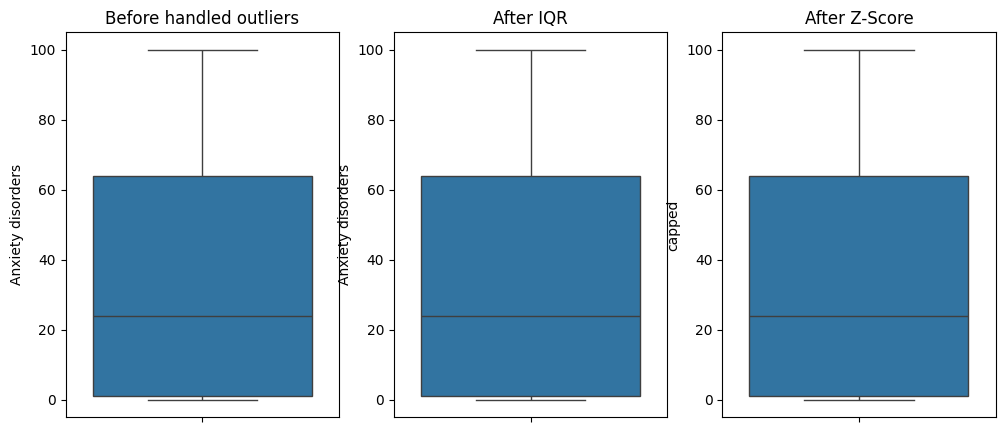

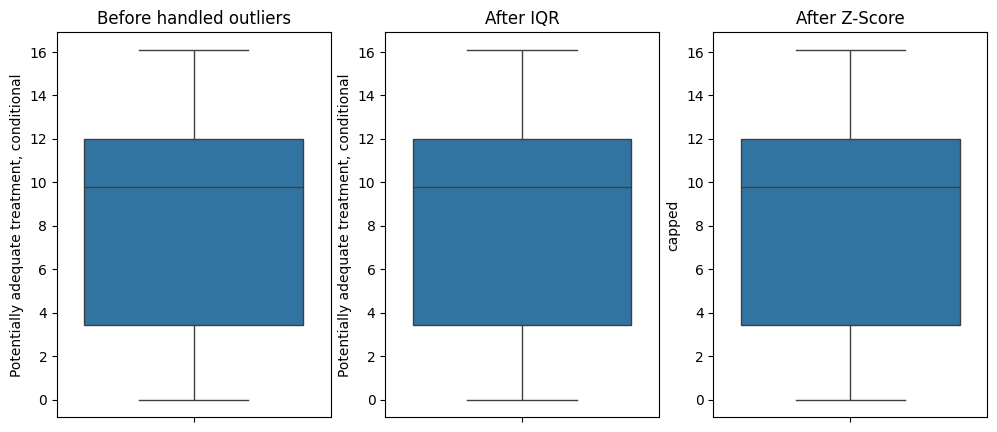

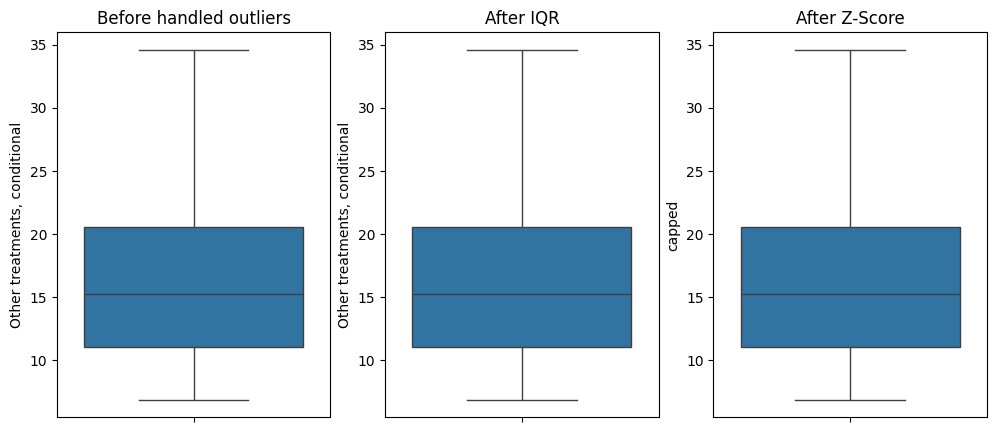

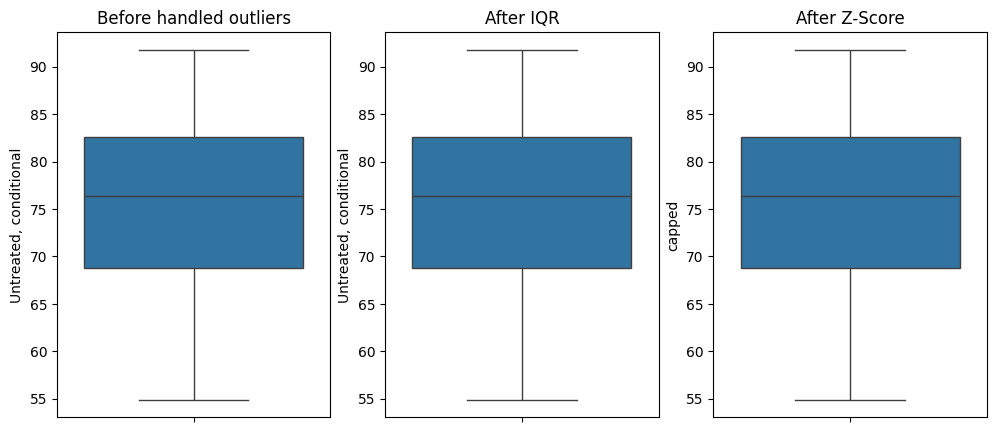

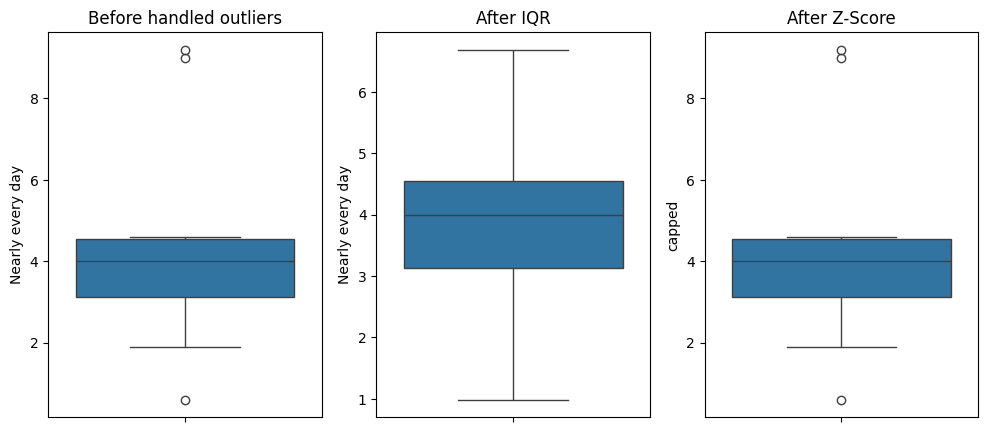

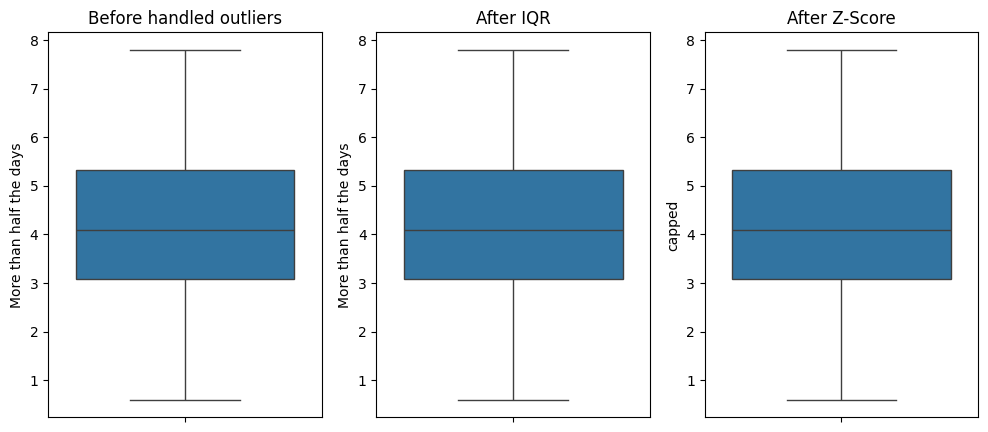

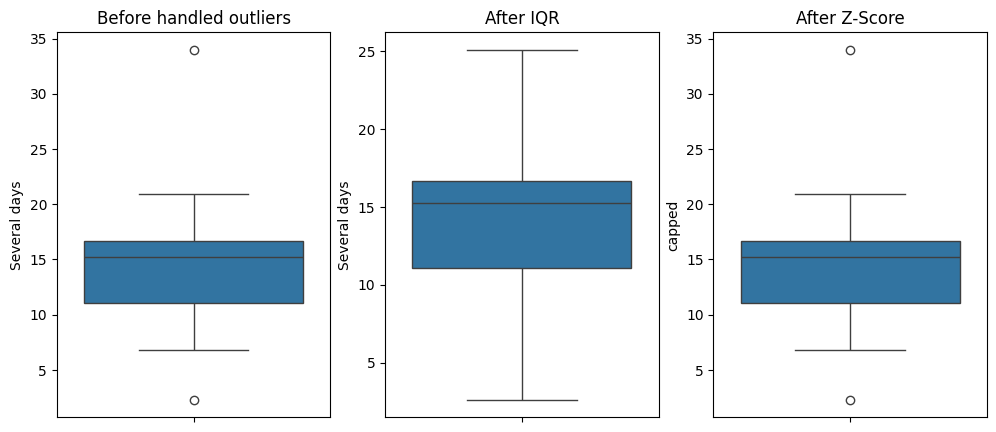

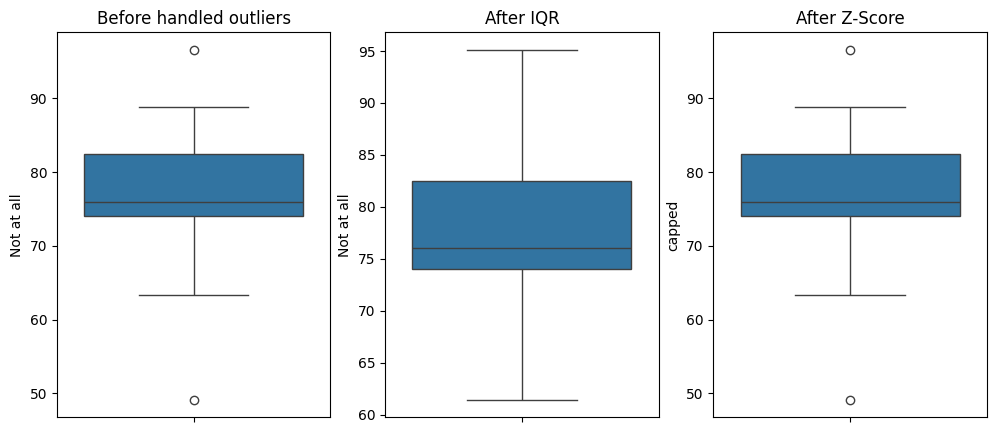

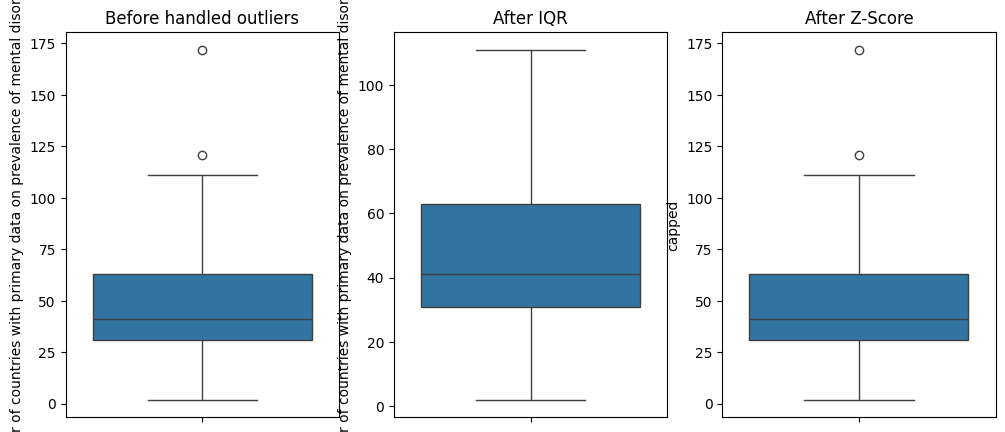

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy.stats import zscore

file_path = "https://api.github.com/repos/AAI500TeamProject/thementalists-project/contents/Dataset/MentalHealth"
response = requests.get(file_path)
files = response.json()

dataframes = {}

#find columns with missing data
for file in files:
    if file['name'].endswith('.csv'):
        file_name = file['name']
        raw_url = file['download_url']  # direct raw file URL
        dataframes[file_name] = pd.read_csv(raw_url)
        print(f"{file_name} missing values: \n {dataframes[file_name].isnull().sum()}")

for file_name in dataframes:
    dataframes[file_name] = dataframes[file_name].drop(columns=['Code']) #drop column "Code" because we have column "Entity" and "Code" won't effect the training process 
    df_skip = dataframes[file_name].iloc[:, 2:]
    df_skip = df_skip.apply(pd.to_numeric, errors='coerce') #while developing, detect some values are string type, so using this to safely convert them into numeric

    for column in df_skip:

        #draw boxplot before analyte to visualize the outliers
        fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
        sns.boxplot(y=df_skip[column], ax=axes[0]) 
        axes[0].set_title(f'Before handled outliers')

        #handle outliers using IQR
        Q1 = df_skip[column].quantile(0.25)
        Q3 = df_skip[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_iqr = df_skip[[column]].copy()
        df_iqr[column]= df_skip[column].clip(lower=lower_bound, upper=upper_bound)

        #draw boxplot after handling outliers
        sns.boxplot(y=df_iqr[column], ax=axes[1])
        axes[1].set_title(f'After IQR')

        # Try z-score method to compare results with IQR method
        df_z = df_skip[[column]].copy()
        df_z['z_score'] = zscore(df_z[column]) 
        df_z['capped'] = df_z[column].where(df_z['z_score'].abs() <= 3) #created capped column to cap values smaller or equal to z-score 3 which is 99.7%

        sns.boxplot(y=df_z['capped'].dropna(), ax=axes[2]) 
        axes[2].set_title(f'After Z-Score')
        plt.show()

   
        